# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [7]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [8]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [9]:
# Import the necessary CSVs to Pandas DataFrames
sfo_data_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(sfo_data_path, index_col="year")

locations_path = Path("Data/neighborhoods_coordinates.csv")
neighborhood_locations_df = pd.read_csv(locations_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [13]:
# Define Panel Visualization Functions

avg_housing_units_per_year = sfo_data['housing_units'].groupby('year').mean()
sales_rent = round(sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby('year').mean(),2)
sfo_df = sfo_data.groupby(['year', 'neighborhood']).mean()
top_10_most_expensive = sfo_data.groupby('neighborhood').mean().sort_values(ascending=False, by='sale_price_sqr_foot')

def housing_units_per_year():
    """Housing Units Per Year."""
    
    min_units = min(avg_housing_units_per_year)
    max_units = max(avg_housing_units_per_year)
    std_units = avg_housing_units_per_year.std()

    housing_units_plot = plt.bar(
    avg_housing_units_per_year.index,
    avg_housing_units_per_year,
    )
    plt.ylim(
        (min_units - std_units),
        (max_units + std_units)
    )
    plt.suptitle(
    'Housing Units in San Francisco from 2010 to 2016',
    weight='bold'
    )
    plt.xlabel('Year')
    plt.ylabel('Housing Units')
   
    return housing_units_plot


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    gross_rent_plot = plt.plot(
        sales_rent.index, 
        sales_rent['sale_price_sqr_foot']
    )
    plt.xlim(
        sales_rent.index[0],
        sales_rent.index[-1]
    )
    plt.suptitle(
        'Average Sale Price per Square Foot in San Francisco', 
        weight='bold'
    )
    plt.xlabel('Year')
    plt.ylabel('Avg. Sale Price')

    return gross_rent_plot
    
def average_sales_price():
    """Average Sales Price Per Year."""
    
    sales_price_plot = plt.plot(
        sales_rent.index, 
        sales_rent['gross_rent']
    )
    plt.xlim(
        sales_rent.index[0],
        sales_rent.index[-1]
    )
    plt.suptitle(
        'Average Gross Rent in San Francisco',
        weight='bold'
    )
    plt.xlabel('Year')
    plt.ylabel('Gross Rent')

    return sales_price_plot

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    price_neighborhood_plot = sfo_df['sale_price_sqr_foot'].hvplot(
        xlabel='Year',
        ylabel='Average price per square foot',
        label=' ',
        groupby='neighborhood',
    )

    return price_neighborhood_plot

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    top_most_expensive_neighborhoods_plot = top_10_most_expensive['sale_price_sqr_foot'].head(10).hvplot.bar(
        ylabel='Average sale price per square foot',
        xlabel='Neighborhood',
        label='Top 10 Most Expensive Neighborhoods',
        rot=30,
        height=300,
        width=600,
    ) 
    
    return top_most_expensive_neighborhoods_plot

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    most_expensive_neighborhoods_rent_sales_plot =sfo_df.hvplot.bar(x= 'year', y=['sale_price_sqr_foot', 'gross_rent'], groupby= 'neighborhood')
    
    return most_expensive_neighborhoods_rent_sales_plot
    

def neighborhood_map():
    """Neighborhood Map."""

    neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    neighborhoods.reset_index(inplace=True)
    neighborhoods.rename(columns={"neighborhood": "Neighborhood"}, inplace=True)
    
    neighborhoods = pd.merge(
        neighborhood_locations_df, neighborhoods, on="Neighborhood"
    )
    
    neighborhood_map = px.scatter_mapbox(
    neighborhoods,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    hover_name="Neighborhood",
    title="Averange Sale Price Per Square Foot and Gross Rent in San Francisco",
    )

    return neighborhood_map


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

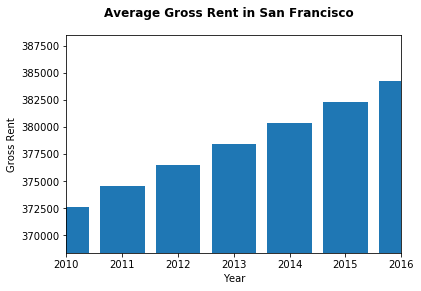

In [14]:
sf_market_plots = pn.Column(
    '## Housing Market Overview',
    housing_units_per_year(),
    average_gross_rent(),
    average_sales_price(),
)

neighborhood_plots = pn.Column(
    '## Neighborhoods Overview',
    average_price_by_neighborhood(),
    top_most_expensive_neighborhoods(),
    )


neighborhood_map = pn.Column(
    '## Neighborhood Map',
    neighborhood_map(),
)

dashboard = pn.Tabs(
    ('Housing Market', sf_market_plots),
    ('Neighborhoods', neighborhood_plots),
    ('Neighborhood Map', neighborhood_map),
)


## Serve the Panel Dashboard

In [15]:
# Serve the# dashboard
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Str(BarContainer)
        [2] Str(list)
        [3] Str(list)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] HoloViews(Bars)
    [2] Column
        [0] Markdown(str)
        [1] Plotly(Figure)